# Title: Alert Investigation (Process Alerts)
LogAnalytics
Version 0.3
## Description:
Series of modules designed to help get a better understanding of the context of a process-based alert.


<a id='toc'></a>
## Table of Contents
- [Setup](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#selectalert)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Entity Graph](#entitygraph)
- [Get time boundaries for subsequent queries](#setquerytimeboundaries)
- [Past Alerts](#previous_alerts)
- [Check for IOCs in Commandline](#cmdlineiocs)
  - [VirusTotal lookup](#virustotallookup)
  - [Interflow lookup](#interflowlookup)
- [Alert command line - Occurrence on other hosts in subscription](#cmdlineonotherhosts)
- [Process Session](#process_session)
  - [Show Session Process Tree](#processtree)
  - [Process Timeline](#processtimeline)
  - [Prevalence of processes in subscription compared with Alert host](#processprevalence)
  - [Comparison of alert logon session processes with previous sessions on host](#sessioncomparison)
- [Alert Account](#logonaccount)
  - [Basic Logon Information](#basiclogon)
  - [Time distribution of recent logons](#recentlogonpattern)
  - [Logon failures](#logonfailures)
- [Report Summary (TBD)](#reportsummary)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#toc)
# Setup

1. Make sure that you have installed packages specified in the setup (uncomment the lines to execute)
2. There are some manual steps up to selecting the alert ID. After this most of the notebook can be executed sequentially
3. Major sections should be executable independently (e.g. Alert Account can be run skipping Process Session)

## Install Packages

In [ ]:
# You will need these packages - should only need to uncomment and run once.
# !pip install msgpack

# # Since this has prequent updates it might be good to leave this uncommented
!pip install Kqlmagic --no-cache-dir  --upgrade

# !pip install PyHamcrest
# # should not need this for current notebook.
# #!conda install -c conda-forge python-levenshtein -y
# !pip install bokeh
# !pip install holoviews
# !pip install seaborn
# !pip install pythonnet


### Imports

In [2]:
#Imports
import numpy as np
import scipy.linalg as lin
#import Levenshtein as leven
from IPython import get_ipython
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interactive, Layout, Select, IntSlider

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)


In [2]:
# TODO - add this to hide code cells
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show/Hide Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

Kusto functions setup

In [4]:
# Kusto utility functions
# Allows printing of query with stripped commments and newline chars
def print_kql(query):
    print(clean_kql_query(query))

def clean_kql_query(query_string):
    import re
    return re.sub(r'(//[^\"\'\n]+)', '', query_string, re.MULTILINE).replace('\n', '').strip()

def execute_kql_query(query_string):
    if not query_string or len(query_string.strip()) == 0:
        print('No query supplied')
        return None
    src_query = clean_kql_query(query_string)
    magic_string = f'results_frame << {src_query}'
    magic_string = magic_string
    ip = get_ipython()
    ip.run_line_magic('kql', magic_string)
    return results_frame


# Query setup for LogAnalytics
security_alert_source = 'SecurityAlert'
security_alert_project = '''| project TenantId,
StartTimeUtc = StartTime,
EndTimeUtc = EndTime,
ProviderAlertId = VendorOriginalId,
SystemAlertId,
ProviderName,
VendorName,
AlertType = AlertName,
AlertName,
AlertDisplayName = DisplayName,
Description,
Severity = AlertSeverity,
IsIncident,
ExtendedProperties,
Entities,
ConfidenceLevel,
ConfidenceScore,
ExtendedLinks,
WorkspaceSubscriptionId,
WorkspaceResourceGroup,
TimeGenerated,
ResourceId,
SourceComputerId '''

# Process Creation 4688
proc_create_eventsource = 'SecurityEvent | where EventID == 4688'
process_create_project = '''| project TenantId,
Account,
EventID,
TimeGenerated,
Computer,
SubjectUserSid,
SubjectUserName,
SubjectDomainName,
SubjectLogonId,
NewProcessId,
NewProcessName,
TokenElevationType,
ProcessId,
CommandLine,
ParentProcessName,
TargetLogonId,
SourceComputerId
| extend TimeCreatedUtc=TimeGenerated '''

# Account Logon 4624 (also works for 4625)
account_logon_eventsource = 'SecurityEvent | where EventID == 4624'
account_logon_project = '''| project TenantId,
Account,
EventID,
TimeGenerated,
SourceComputerId,
Computer,
SubjectUserName,
SubjectDomainName,
SubjectUserSid,
TargetUserName,
TargetDomainName,
TargetUserSid,
TargetLogonId,
LogonProcessName,
LogonType,
AuthenticationPackageName,
Status,
IpAddress,
WorkstationName
| extend TimeCreatedUtc=TimeGenerated '''

toggle_code()

<a id='enterworkspace'></a>[Contents](#toc)
### Enter or Confirm Workspace ID

In [5]:
import os
from ipywidgets import widgets, Select, Layout, interactive, Label
def text_input_widget(description, defaultvalue):
    return widgets.Text(value=defaultvalue, description=description, layout = Layout(width='50%'),
                        style = {'description_width': 'initial'})

help_str = '''To find your workspace ID go to 
<a href='https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces'>
Azure Operational Insights portal</a>.
 Click on your log analytics workspace and copy the workspace ID from the Properties blade.'''
WORKSPACEID = os.environ.get('WORKSPACEID')
if WORKSPACEID == None or len(WORKSPACEID) == 0:
    display(widgets.HTML(value=help_str))
    
wstext = text_input_widget('Azure Security Insights Workspace ID:', WORKSPACEID)
save_button = widgets.Button(description='Set', layout = Layout(width='10%', disabled=False),
                             style = {'description_width': 'initial'})
check_save = widgets.Checkbox(value=True, description='Save as environment var', disabled=False)

def on_save_button_clicked(b):
    if check_save.value:
        os.environ['WORKSPACEID'] = wstext.value

save_button.on_click(on_save_button_clicked)  
hbox = widgets.HBox([wstext, save_button, check_save])
display(hbox)

HTML(value="To find your workspace ID go to \n<a href='https://ms.portal.azure.com/#blade/HubsExtension/Resour…

In [7]:
# Internal Version to choose from multiple demon workspaces
from ipywidgets import widgets, Select, Layout, interactive
available_workspaces = {'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359'}

alertId = ''
def select_workspace(x=''):
    global la_workspace
    la_workspace = available_workspaces[x]
     
selected_workspace = widgets.Select(options=available_workspaces.keys(), 
                              description='Select workspace :',
                              layout=Layout(width='50%', height='100px'),
                              style = {'description_width': 'initial'})
interactive(select_workspace, x=selected_workspace)


interactive(children=(Select(description='Select workspace :', layout=Layout(height='100px', width='50%'), opt…

### Authenticate to Log Analytics

In [8]:
# KqlMagic
%reload_ext Kqlmagic
%config Kqlmagic.auto_dataframe=True
%kql loganalytics://code().workspace(la_workspace)

# Alternative syntax if you are using an AAD AppID instead of user/device authentication
#%kql loganalytics://tenant(aad_tenant).workspace(la_workspace).clientid(reader_client_id).clientsecret(reader_client_secret)

<a id='getalertslist'></a>[Contents](#toc)
# Get Alerts List

**Note**: this is a placeholder section. We need something a bit more intelligent and flexible but that possibly belongs in another notebook. The purpose here is simply to get a list of subscriptions and alerts to test out the rest of the notebook.

In [9]:
get_alerts_count_tmplt = '''
{table}
{query_project}
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| summarize alertCount=count(), firstAlert=min(StartTimeUtc), lastAlert=max(StartTimeUtc) by AlertName
| order by alertCount desc
'''.format(table = security_alert_source, query_project=security_alert_project, start = '{start}', end = '{end}')


get_alerts_tmplt ='''
{table}
{query_project}
| where TimeGenerated >= datetime({start})
| where TimeGenerated > datetime({end})
| extend extendedProps = parse_json(ExtendedProperties) 
| extend CompromisedEntity = tostring(extendedProps['Compromised Host'])
| project-away extendedProps
'''.format(table = security_alert_source, query_project=security_alert_project, start = '{start}', end = '{end}' )




In [3]:
from datetime import datetime, timedelta
class QueryTime:
    _label_style = {'description_width': 'initial'}
    
    def __init__(self, origin_time : datetime = None, before=60, after=10, max_before=600, max_after=100):
        # default to now
        self.origin_time = datetime.utcnow() if origin_time is None else origin_time
        
        # Calculate default time offsets from origin
        self._queryStart = self.origin_time - timedelta(0, before * 60)
        self._queryEnd = self.origin_time + timedelta(0, after * 60)
        
        # Create widgets
        self._w_origin_dt = widgets.DatePicker(description='Origin Date', disabled=False, value = self.origin_time.date())
        self._w_origin_tm = widgets.Text(description='Time (24hr)', disabled=False, value = str(self.origin_time.time()))
        
        self._w_tm_range = widgets.IntRangeSlider(value=[-before, after], min=-max_before, max=max_after, step=1, 
                                                  description='Time Range (min):', disabled=False, 
                                                  continuous_update=True, orientation='horizontal',
                                                  readout=True, readout_format='d', layout=Layout(width='80%'),
                                                  style=self._label_style)
        
        self._w_startTime_txt = widgets.Text(value=self._queryStart.isoformat(sep=' '),
                                             description='Query start time (UTC):',
                                             layout = Layout(width='50%'), style = self._label_style)
        self._w_endTime_txt = widgets.Text(value=self._queryStart.isoformat(sep=' '),
                                           description='Query end time (UTC) :  ',
                                           layout = Layout(width='50%'), style = self._label_style)
    
        self._w_tm_range.observe(self._time_range_change, names='value')
        self._w_origin_dt.observe(self._update_origin, names='value')
        self._w_origin_tm.observe(self._update_origin, names='value')
        
    def display(self):
        display(widgets.HTML('<h4>Set query time boundaries</h4>'))
        display(widgets.HBox([self._w_origin_dt, self._w_origin_tm]))
        display(widgets.VBox([self._w_tm_range, self._w_startTime_txt, self._w_endTime_txt]))

    def _update_origin(self, change):
        try:
            tm_value = datetime.strptime(self._w_origin_tm.value, '%H:%M:%S.%f').time()
            self.origin_time = datetime.combine(self._w_origin_dt.value, tm_value)
            self._time_range_change(change=None)
        except:
            pass

    def _time_range_change(self, change):
        self._queryStart = self.origin_time + timedelta(0, self._w_tm_range.value[0] * 60)
        self._queryEnd = self.origin_time + timedelta(0, self._w_tm_range.value[1] * 60)
        self._w_startTime_txt.value = self._queryStart.isoformat(sep=' ')
        self._w_endTime_txt.value = self._queryEnd.isoformat(sep=' ')
    
    @property
    def start(self):
        return self._queryStart
    
    @property
    def end(self):
        return self._queryEnd

qt = QueryTime()
qt.display()


HTML(value='<h4>Set query time boundaries</h4>')

In [12]:
get_alerts_count_query = get_alerts_count_tmplt.format(start = qt.start, end = qt.end)
get_alerts_query = get_alerts_tmplt.format(start = qt.start, end = qt.end)

alert_counts = execute_kql_query(get_alerts_count_query)
last_alerts = execute_kql_query(get_alerts_query)
display(alert_counts)

,AlertName,alertCount,firstAlert,lastAlert
0,Potential reverse shell detected,5,2018-12-17 20:15:09,2018-12-18 00:15:07
1,Screenshot taken on host,5,2018-12-17 20:15:14,2018-12-18 00:15:09
2,Detected file download from a known malicious source,5,2018-12-17 20:15:08,2018-12-18 00:15:06
3,Detected Persistence Attempt,5,2018-12-17 20:15:03,2018-12-18 00:15:02
4,New SSH key added,5,2018-12-17 20:15:03,2018-12-18 00:15:02
5,An history file has been cleared,5,2018-12-17 20:15:04,2018-12-18 00:15:02
6,Behavior similar to common Linux bots detected,5,2018-12-17 20:15:04,2018-12-18 00:15:03
7,Manipulation of host firewall detected,5,2018-12-17 20:15:06,2018-12-18 00:15:04
8,Suspicious Download Then Run Activity,5,2018-12-17 20:15:06,2018-12-18 00:15:05
9,Behavior similar to Fairware ransomware detected,5,2018-12-17 20:15:06,2018-12-18 00:15:05


<a id='selectalert'></a>[Contents](#toc)
# Choose Alert to Investigate
Choose from list of retrieved alerts or paste the alert Id here [EnterAlertId](#enteralertid)

In [14]:
from IPython.core.display import HTML

# Fetch and alert
def fetch_alert(alertproviderId, local_cache=None):
    
    if local_cache is not None:
        alerts = local_cache[local_cache['ProviderAlertId'] == alertproviderId]
    else:
        # Get alert
        getAlertQuery = f'{get_alerts_query} | where ProviderAlertId == \'{alertproviderId}\''
        alerts = execute_kql_query(getAlertQuery)
        
    if alerts.shape[0] > 0:
        investigatedAlert = pd.Series(alerts.iloc[0])
        if isinstance(investigatedAlert['ExtendedProperties'], str):
            investigatedAlert['ExtendedProperties'] = json.loads((investigatedAlert['ExtendedProperties']))
        if isinstance(investigatedAlert['Entities'], str):
            investigatedAlert['Entities'] = json.loads((investigatedAlert['Entities']))
        return investigatedAlert
    
def display_alert(investigatedAlert=None):
    if investigatedAlert is not None:
        # Display raw properties
        display(pd.DataFrame(investigatedAlert))
        if 'ExtendedProperties' in investigatedAlert:
            display(HTML('<b>ExtendedProperties:<b>'))
            display(pd.io.json.json_normalize(investigatedAlert['ExtendedProperties']).T)
            
        if 'Entities' in investigatedAlert:
            display(HTML('<b>Entities:</b>'))
            for e in investigatedAlert['Entities']:
                display(widgets.Label(value='    {}'.format(e)))
        

## Select alert from list

In [16]:
# Select and view alert
import re
import json
from ipywidgets import interactive, Layout


items = last_alerts[['StartTimeUtc', 'AlertName', 'ProviderAlertId']].sort_values('StartTimeUtc')\
.apply(lambda x: '{time}  {alert} [id:{id}]'.format(time=x.StartTimeUtc, alert=x.AlertName, id=x.ProviderAlertId),
       axis=1 ).values.tolist()

alertid_regex= r'\[id:(?P<alert_id>[\da-fA-F]{8}-(?:[\da-fA-F]{4}-){3}[\da-fA-F]{12})\]$'
alertId = ''
def view_alert(x=''):
    global investigatedAlert
    global alertId
    if x is None:
        return
    m = re.search(alertid_regex, x)
    if m is not None:
        alertId = m.groupdict()['alert_id']
        display(HTML('<h5>Alert: {id}</h5>'.format(id=alertId)))
        investigatedAlert = fetch_alert(alertId, local_cache=last_alerts)
        display_alert(investigatedAlert)
    
 
selected_alert = widgets.Select(options=items, 
                              description='Select alert :',
                              layout=Layout(width='80%', height='200px'),
                              style = {'description_width': 'initial'})


filter_alerts = widgets.Text(value='', description='Filter alerts by title:', 
                             style = {'description_width': 'initial'} )
def update_options(change):
    if change is not None and 'new' in change:
        selected_alert.options = [ i for i in items if change['new'] in i]
    
filter_alerts.observe(update_options, names='value')
display(filter_alerts)
interactive(view_alert, x=selected_alert)

Text(value='', description='Filter alerts by title:', style=DescriptionStyle(description_width='initial'))

interactive(children=(Select(description='Select alert :', layout=Layout(height='200px', width='80%'), options…

<a id='enteralertid'></a>[Contents](#toc)
### Or paste in an alert ID and fetch it
**Skip this section if you selected from the above list**

In [17]:
# Allow alert to be selected
# Allow subscription to be selected
targetAlertW = widgets.Text(
    value=alertId,
    placeholder='ProviderAlertId',
    description='ProviderAlertId for alert :',
    layout = Layout(width='50%'), style = {'description_width': 'initial'})

display(targetAlertW)

def click_get_alert(b):
    global investigatedAlert
    global alertId
    alertId = targetAlertW.value
    if not alertId or not alertId.strip():
        print('Error: AlertID was not entered')
    print('AlertId:', alertId, '\n')
    investigatedAlert = fetch_alert(alertId)
    
fetch_button = widgets.Button(description="Get alert..")
fetch_button.on_click(click_get_alert)
display(fetch_button);

Text(value='91e8cae4-647c-4d3c-ac07-eea594c1b56b', description='ProviderAlertId for alert :', layout=Layout(wi…

Button(description='Get alert..', style=ButtonStyle())

<a id='extractalertproperties'></a>[Contents](#toc)
## Extract properties and entities from Alert

In [18]:
# Get properties from alert entities

def get_entity_property(entityType, entity_property, entities=None, entity=None):
    if entity and entity_property in entity:
        return entity[entity_property]
    if entities is not None:
        if isinstance(entities, list):
            for test_entity in [e for e in entities if e['Type'] == 'entityType']:
                if len(test_entity) > 0 and entity_property in test_entity and is_not_empty(test_entity[entity_property]):
                    return test_entity[entity_property]
        elif isinstance(entities, dict):
            for entity_id, test_entity in entities.items():
                if test_entity['Type'] == entityType:
                    if len(test_entity) > 0 and entity_property in test_entity and is_not_empty(test_entity[entity_property]):
                        return test_entity[entity_property]

def is_not_empty(testObject):
    if testObject:
        if isinstance(testObject, str):
            if testObject.strip():
                #testObject is not None AND myString is not empty or blank
                return True
            else:
                return False
        elif testObject:
            return True
        
    #testObject is None OR testObject is empty or blank
    return False

def get_file_for_process(process, files):
    if 'ImageFile' in process:
        file = process['ImageFile']
        if '$ref' in process['ImageFile']:
            fileId = process['ImageFile']['$ref']
            pfiles = [f for f in files if fileId == f['$id']]
            return pfiles[0] if len(pfiles) > 0 else None
        else:
            if(type(process['ImageFile']) == list):
                return process['ImageFile'][0]
            return process['ImageFile']
    else:
        return 'unknown'
    
def get_process_and_parent(entities):
    processes = [t for t in entities if t['Type'] == 'process']
    if not processes:
        return (None, None)
    files = [t for t in entities if t['Type'] == 'file']
    
    if len(processes) == 0:
        return
    if len(processes) == 1:
        childprocess = processes[0]
        childprocess['ImageFile'] = get_file_for_process(childprocess, files)
        return (childprocess, None)
    if len(processes) > 1:
        for process in processes:
            if('ParentProcess' in process and '$ref' in process['ParentProcess']):
                childprocess = process
                childprocess['ImageFile'] = get_file_for_process(process, files)
                ppid = process['ParentProcess']['$ref']
                parentprocesses = [p for p in processes if ppid == p['$id']]
                if len(parentprocesses) > 0:
                    parentprocess = parentprocesses[0]
                    parentprocess['ImageFile'] = get_file_for_process(parentprocess, files)                 
                return (childprocess, parentprocess)          



def get_alert_ids(alert=investigatedAlert):
    id_properties = ['AzSubscriptionId', 'AzResourceId', 
                                       'WorkspaceId', 'AgentId', 
                                       'TenantId', 'SourceComputerId', 'ResourceId',
                                        'WorkspaceSubscriptionId', 'WorkspaceResourceGroup']
    ids = dict()
    for id_property in id_properties:
        if id_property in investigatedAlert:
            ids[id_property] = investigatedAlert[id_property]
    return ids


def alert_in_workspace(alert=investigatedAlert):
    ids = get_alert_ids(alert)
    return ('WorkSpaceId' in ids and 'AgentId' in ids)

def alert_in_log_analytics(alert=investigatedAlert):
    ids = get_alert_ids(alert)
    return ('TenantId' in ids and 'SourceComputerId' in ids)

def alert_in_azure_sub(alert=investigatedAlert):
    ids = get_alert_ids(alert)
    return ('AzSubscriptionId' in ids and 'AzResourceId' in ids)

def kql_subscription_filter(alert=investigatedAlert, operator='=='):
    ids = get_alert_ids(alert)
    if alert_in_log_analytics(alert):
        return 'TenantId {} \'{}\''.format(operator, ids['TenantId'])
    elif alert_is_in_azure_sub(alert):
        return 'AzureResourceSubscriptionId {} \'{}\''.format(operator, ids['AzSubscriptionId'])
    else:
        return 'WorkspaceId {} \'{}\''.format(operator, ids['WorkspaceId'])
    
def kql_host_filter(alert=investigatedAlert, operator='=='):
    ids = get_alert_ids(alert)
    if alert_in_log_analytics(alert):
        return 'SourceComputerId {} \'{}\''.format(operator, ids['SourceComputerId'])
    elif alert_is_in_azure_sub(alert):
        return 'AzureResourceId {} \'{}\''.format(operator, ids['AzResourceId'])
    else:
        return 'AgentId {} \'{}\''.format(operator, ids['AgentId'])
    
def escape_windows_path(str_path):
    if is_not_empty(str_path):
        return str_path.replace('\\', '\\\\')
    
def unescape_windows_path(str_path):
    if is_not_empty(str_path):
        return str_path.replace('\\\\', '\\')

def get_alert_entities(alert=investigatedAlert, entity_type='host'):
    return [p for p in alert.extracted_entities.values() if p['Type'] == entity_type]

def get_alert_process(alert=investigatedAlert):
    procs = get_alert_entities(alert, 'process')
    if procs is None or len(procs) == 0:
        return None
    if len(procs) == 1:
        return procs[0]
    else:
        # find the first process that has a parent process property
        proc = [p for p in procs if 'ParentProcess' in p]
        if len(proc) > 0:
            return proc[0]

def get_process_name(process, separator='\\'):
    if process != None and 'ImageFile' in process:
        if 'Directory' in process['ImageFile']:
            if '/' in process['ImageFile']['Directory']:
                separator = '/'
            return process['ImageFile']['Directory'] + separator + process['ImageFile']['Name']
        else:
            return process['ImageFile']['Name']
        
def get_alert_process_name(alert=investigatedAlert):
    process = get_alert_process(alert)
    if ('os_family' in alert and alert['os_family'] == 'Linux'
        or '/' in process['ImageFile']['Directory']):
        return get_process_name(process, '/')
    else:
        return get_process_name(process, '\\')


def get_alert_account_name(alert=investigatedAlert):
    accts = get_alert_entities(alert, 'account')
    if len(accts) > 0:
        acct = accts[0]
        if 'Name' in acct:
            name = acct['Name']
        if 'NTDomain' in acct:
            return '{}\\{}'.format(acct['NTDomain'], name)
        else:
            return name
    
# We can try to extract extended properties but it's difficult to rely on the name 
# of things we might need.
ext_properties = investigatedAlert['ExtendedProperties']
if 'account logon id' in ext_properties:
    accountLogonId = ext_properties['account logon id']
elif 'Account Session Id' in ext_properties:
    accountLogonId = ext_properties['Account Session Id']

if 'Compromised Host' in ext_properties:
    hostname = ext_properties['Compromised Host']

if 'Suspicious Process' in ext_properties:
    processPath = ext_properties['Suspicious Process']

if 'User Name' in ext_properties:
    accountName = ext_properties['User Name']

# Better to rely on entities for most things
alertEntities = investigatedAlert['Entities']

# HostentityType, entity_property
hostname = get_entity_property(entities=alertEntities, entityType='host', entity_property='HostName')
hostdomain = get_entity_property(entities=alertEntities, entityType='host', entity_property='DnsDomain')
if is_not_empty(hostdomain):
    computer = hostname + '.' + hostdomain
else:
    computer = hostname

# get some other properties
ip = get_entity_property(entities=alertEntities, entityType='ip', entity_property='Address')
dnsdom = get_entity_property(entities=alertEntities, entityType='dns', entity_property='DomainName')
iploc = get_entity_property(entities=alertEntities, entityType='ip', entity_property='Location')
hostip = get_entity_property(entities=alertEntities, entityType='dns', entity_property='HostIpAddress')
if not is_not_empty(accountLogonId):
    accountLogonId = get_entity_property(entities=alertEntities, entityType='account', entity_property='LogonId')

all_alert_entities = dict()
# add entities to dictionary to remove dups
for e in alertEntities:
    all_alert_entities[e['$id']] = e
    

# work out which path separator to use from OSFamily
path_separator = '\\'
os_family = 'Windows'
for os_entity in [e for e in all_alert_entities.values() if 'OSFamily' in e]:
    if os_entity['OSFamily'] == 'Linux':
        print
        os_family='Linux'
        path_separator = '/'
        break;

# Drop any items that might have been added from previous run of this
if 'path_separator' not in investigatedAlert.index:
    investigatedAlert['path_separator'] = path_separator
if 'os_family' not in investigatedAlert.index:
    investigatedAlert['os_family'] = os_family


process, parentprocess = get_process_and_parent(alertEntities)
if process != None:
    processId = get_entity_property(entity=process, entityType='process', entity_property='ProcessId')
    # if processId is not defined in the entity, see if it in the extended propertiers
    if not processId:
        for pid_property in ['Process Id', 'Suspicious Process Id']:
            if pid_property in ext_properties:
                process['ProcessId'] = ext_properties[pid_property]
                break
    # we get better fidelity entities for process and parent from get_process_and_parent
    # so overwrite this
    all_alert_entities[process['$id']] = process
    
if parentprocess != None:
    # we get better fidelity entities for process and parent from get_process_and_parent
    # so overwrite this
    all_alert_entities[parentprocess['$id']] = parentprocess

if 'extracted_entities' not in investigatedAlert.index:
    investigatedAlert['extracted_entities'] = all_alert_entities

print('done')

done


In [39]:
# For some alerts we may not have the parent process. So try to get this if needed
if process is not None and parentprocess is None:
    # try to retrieve this from the logs
    sourceProcessId = process['ProcessId']
    sourceProcessName = escape_windows_path(get_process_name(process))
    startTime = investigatedAlert['StartTimeUtc']
    
    query = '''let start = datetime({start});
    let end = datetime({end});
    let sourceProcessId = \'{sourceProcessId}\';
    let sourceProcess = 
    materialize(
        {event_source}
        {project_statement}
        | where {subscription_filter}
        | where {host_filter}
        | where TimeGenerated >= start - time(10m)
        | where TimeGenerated <= end
        | where NewProcessId == sourceProcessId
        | where NewProcessName =~ \'{processName}\'
        | extend NodeRole = 'source', Level = 0);
    let sourceTimeCreatedUtc = toscalar(sourceProcess | project TimeCreatedUtc | top 1 by TimeCreatedUtc desc nulls last);
    let sourceLogonId = toscalar(sourceProcess | top 1 by TimeCreatedUtc desc nulls last | project SubjectLogonId);
    let sourceParentProcessId = toscalar(sourceProcess | top 1 by TimeCreatedUtc desc nulls last | project ProcessId);
    sourceProcess
    | union(
        {event_source}
        {project_statement}
        | where {subscription_filter}
        | where {host_filter}
        | where TimeGenerated >= start - time(24h)
        | where TimeGenerated <= end
        | where TimeGenerated <= sourceTimeCreatedUtc
        | where SubjectLogonId == sourceLogonId
        | where NewProcessId == sourceParentProcessId
        | extend NodeRole = 'parent', Level = 1
        | top 1 by TimeCreatedUtc desc nulls last)
    '''.format(event_source = proc_create_eventsource,
            project_statement = proc_create_project,
            subscription_filter = kql_subscription_filter(investigatedAlert),
            host_filter = kql_host_filter(investigatedAlert),
            start = startTime,
            end = startTime,
            sourceProcessId = sourceProcessId,
            processName = sourceProcessName)
    
    process_results = execute_kql_query(query)
    
 

<a id='entitygraph'></a>[Contents](#toc)
## Entity Graph

In [19]:
# Build the Networkx graph
alertentity_graph = nx.Graph(id='AlertGraph')

def get_name_and_description(entity):
    e_name = None
    e_description = None
    
    if(entity['Type'] == 'host'):
        if 'DnsDomain' in entity and is_not_empty(entity['DnsDomain']):
            e_name = '{}.{}'.format(entity['HostName'], entity['DnsDomain'])
        elif 'NTDomain' in entity and is_not_empty(entity['NTDomain']):
            e_name = '{}/{}'.format(entity['NTDomain'], entity['HostName'])                                 
        else:
            e_name = entity['HostName']
        e_name = '{}: {}'.format(entity['Type'], e_name)
        if 'IsDomainJoined' in entity:
            domain_joined = entity['IsDomainJoined']
        else:
            domain_joined = 'false'
        if 'OSFamily' in entity:
            os_family = entity['OSFamily']
        else:
            os_family = OS_family
        e_description = '{}\n({}, Domain-joined: {})'.format(e_name, os_family, domain_joined)
    
    elif entity['Type'] == 'account':
        e_name = (entity['NTDomain'] + '\\' if 'NTDomain' in entity else '') +  entity['Name']
        e_name = '{}: {}'.format(entity['Type'], e_name)
        if 'IsDomainJoined' in entity:
            domain_joined = entity['IsDomainJoined']
        else:
            domain_joined = 'false'
        if 'LogonId' in entity:
            e_description = '{}\n(LogonId: {}, Domain-joined: {})'.format(e_name, entity['LogonId'], domain_joined)
        else:
            e_description = '{}\n(Domain-joined: {})'.format(e_name, domain_joined)
    
    elif entity['Type'] == 'host-logon-session':
        #{'$id': '3', 'SessionId': '0xa5c864ce9', 'StartTimeUtc': '2018-10-29T16:30:56.0008063Z', 'EndTimeUtc': '2018-10-29T16:30:56.0008063Z',
        #'Type': 'host-logon-session', 'Host': {'$ref': '1'}, 'Account': {'$ref': '2'}}
        e_name = 'host-logon-session'
        e_description = 'Logon session {}\n(Start time: {})'.format(entity['SessionId'], entity['StartTimeUtc'])
        
    elif entity['Type'] == 'process':
        if 'ImageFile' in entity and 'Directory' in entity['ImageFile']:
            path = entity['ImageFile']['Directory'] + path_separator + entity['ImageFile']['Name']
        else:
            path = 'unknown'
        e_name =  path + ' [' + entity['ProcessId'] +  ']'
        e_name = '{}: {}'.format(entity['Type'], e_name)
        e_description = '{}\n(cmdline: \'{}\')'.format(e_name, entity['CommandLine'])
        
    elif entity['Type'] == 'file':
        e_name = entity['Directory'] + path_separator + entity['Name']
        e_name = '{}: {}'.format(entity['Type'], e_name) 
        e_description = e_name  
    
    elif entity['Type'] == 'ip':
        e_name = entity['Address']
        e_name = '{}: {}'.format(entity['Type'], e_name)
        if 'Location' in entity:
            e_description = '{}\nc={}, st={}, city={}'.format(
                e_name,
                entity['Location']['CountryCode'],
                entity['Location']['State'],
                entity['Location']['City'])
        else:
            e_description = e_name 
    
    elif entity['Type'] == 'dns':
        e_name = entity['DomainName']
        e_name = '{}: {}'.format(entity['Type'], e_name) 
        e_description = e_name 
    
    else:
        # Any other type of entity
        if 'Name' in entity:
            e_name = entity['Name']
            e_name = '{}: {}'.format(entity['Type'], e_name)
        else:
            e_name = entity['Type']
            
        # Rather nasty expression to join all other items in the dictionary into a string
        e_properties = ', '.join({'{}:{}'.format(k,v) for (k,v) in entity.items() if (k != 'Type') and (k != 'Name')})
        e_description = '{}\n{})'.format(e_name, e_properties)
    
    return e_name, e_description


alertentity_graph.add_node(investigatedAlert['AlertType'], 
                           name=investigatedAlert['AlertType'], 
                           time=str(investigatedAlert['StartTimeUtc']),
                           description='Alert: ' + investigatedAlert['AlertDisplayName'],
                           color='red',
                           node_type='alert'#,
                           #source=investigatedAlert.to_dict()
                          )

path_separator = investigatedAlert['path_separator']
OS_family = investigatedAlert['os_family']

# Cycle through entities
for e in all_alert_entities.values():
    (name, description) = get_name_and_description(e)
    
    alertentity_graph.add_node(name, entitytype=e['Type'], name=name, description=description, color='green', node_type='entity', source=e)

    alertentity_graph.add_edge(investigatedAlert['AlertType'], name)
    
    if e['Type'] == 'host':
        continue
        
    # if this entity has a child object that has a $ref property
    for prop, value in [(p,v) for (p,v) in e.items() if isinstance(v, dict)]:
        # Handle references
        if '$ref' in value:
            id = value['$ref']
        elif '$id' in value and value['$id'] in all_alert_entities:
             id = value['$id']
        else:
            continue
        
        if all_alert_entities[id]['Type'] == 'host':
            continue
            
        if id in all_alert_entities:
            (relatedEntity, desc) = get_name_and_description(all_alert_entities[id])
            if not alertentity_graph.has_edge(relatedEntity, name):
                if alertentity_graph.has_edge(investigatedAlert['AlertType'], relatedEntity):
                    alertentity_graph.remove_edge(investigatedAlert['AlertType'], relatedEntity)
                alertentity_graph.add_edge(name, relatedEntity, description=prop, color='green', weight=1, line_type='SHORT_DASH')

### Plot using Networkx/Matplotlib

<IPython.core.display.Javascript object>


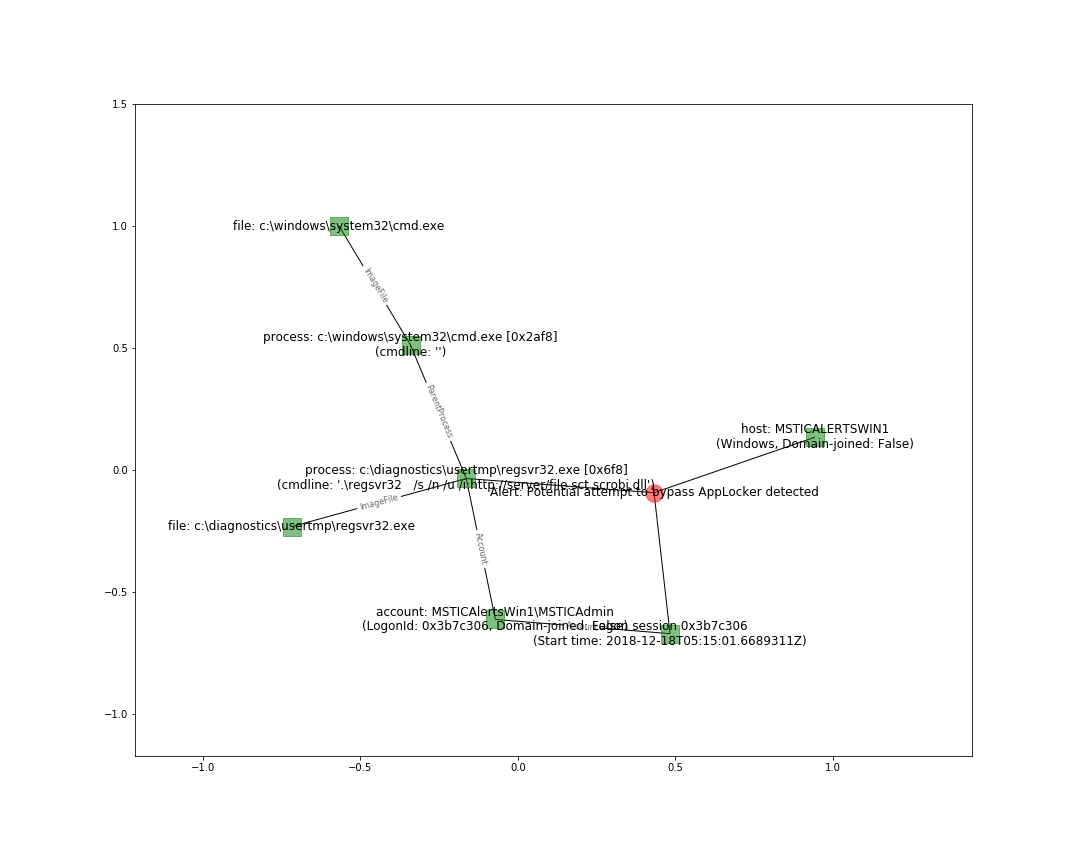

C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



In [20]:
# Draw the graph using Networkx/Matplotlib
%matplotlib notebook
%matplotlib notebook
# extract nodes with specific setting of the attribute
def draw_alert_entity_graph(nx_graph, font_size=12, height=12, width=15, margin=0.3, scale=1, node_dist=3 ):
    alert_node = [n for (n,node_type) in \
        nx.get_node_attributes(nx_graph,'node_type').items() if node_type == 'alert']
    entity_nodes = [n for (n,node_type) in \
        nx.get_node_attributes(nx_graph,'node_type').items() if node_type == 'entity']


    # now draw them in subsets  using the `nodelist` arg
    plt.rcParams['figure.figsize'] = (width,height)

    plt.margins(x=margin, y=margin)
    #pos = nx.spring_layout(nx_graph, fixed=None, scale=scale, k=3, weight='weight')
    pos = nx.kamada_kawai_layout(nx_graph, scale=scale, weight='weight')
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=alert_node, node_color='red', alpha=0.5, node_shape='o')
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=entity_nodes, node_color='green', alpha=0.5, node_shape='s', s=200)#, node_size='500')
    nlabels = nx.get_node_attributes(nx_graph, 'description')
    nx.relabel_nodes(nx_graph, nlabels)
    nx.draw_networkx_labels(nx_graph, pos, nlabels, font_size=font_size)
    nx.draw_networkx_edges(nx_graph, pos)
    elabels = nx.get_edge_attributes(nx_graph, 'description')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=elabels, font_size=font_size * 2/3, alpha=0.6);
    plt.show();

draw_alert_entity_graph(alertentity_graph)

<a id='previous_alerts'></a>[Contents](#toc)
# Previous Alerts
### For entities in the investigated alert

In [21]:
# Calculate query time boundaries
from datetime import timedelta
startTimeUtc = investigatedAlert['StartTimeUtc']
queryStartTimeUtc = startTimeUtc - timedelta(0, 60 * 60)
queryEndTimeUtc = startTimeUtc + timedelta(0, 10 * 60)

historicAlertsDays = widgets.IntSlider(value=7, min=1, max=40, step=1,
                                       description='Days to search:',
                                       layout = Layout(width='50%'),
                                       style = {'description_width': 'initial'})
display(HTML('<h3>Set additional days to look back for past alerts (in days)</h3>'))
display(historicAlertsDays)

IntSlider(value=7, description='Days to search:', layout=Layout(width='50%'), max=40, min=1, style=SliderStyle…

In [22]:
historicalStart = queryStartTimeUtc - timedelta(historicAlertsDays.value)
    
alertProcessName = get_alert_process_name(investigatedAlert)
if investigatedAlert['os_family'] == 'Windows':
    qry_alertProcessName = escape_windows_path(alertProcessName)
else:
    qry_alertProcessName = alertProcessName
    
alertAccountName = get_alert_account_name(investigatedAlert)
if alertAccountName.find('\\') != -1:
    qry_alertAccountName = escape_windows_path(alertAccountName)
else:
    qry_alertAccountName = alertAccountName

query='''
{table_source}
{query_project}
| where {subscription_filter}
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| extend ext_properties=parse_json(ExtendedProperties)
| extend accountName = tostring(ext_properties["User Name"])
| extend processName = tostring(ext_properties["Suspicious Process"])
| where {host_filter} or accountName =~ \'{alertAccountName}\' or processName =~ \'{alertProcessName}\'
| extend host_match = ({host_filter})
| extend acct_match = (accountName =~ \'{alertAccountName}\')
| extend proc_match = (processName =~ \'{alertProcessName}\')
'''.format(table_source=security_alert_source,
           query_project=security_alert_project,
           start=historicalStart, 
           end=queryEndTimeUtc, 
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert),
           alertAccountName = qry_alertAccountName,
          alertProcessName = qry_alertProcessName)

pastAlerts = execute_kql_query(query)

pastAccountAlerts = pastAlerts.query('acct_match == @True')
pastProcessAlerts = pastAlerts.query('proc_match == @True')
pastHostAlerts = pastAlerts.query('host_match == @True')

hostAlertItems = pastHostAlerts[['AlertType', 'StartTimeUtc']].groupby('AlertType').StartTimeUtc.agg('count').to_dict()
acctAlertItems = pastAccountAlerts[['AlertType', 'StartTimeUtc']].groupby('AlertType').StartTimeUtc.agg('count').to_dict()
procAlertItems = pastProcessAlerts[['AlertType', 'StartTimeUtc']].groupby('AlertType').StartTimeUtc.agg('count').to_dict()

alertHostName = get_entity_property('host', 'HostName', entities=investigatedAlert['extracted_entities'])

display(HTML('<h4>Previous related alerts</h4>'))
def print_related_alerts(alertDict, entityType, entityName):
    if len(alertDict) > 0:
        display(HTML('<b>Found {} different alert types related to this {} (\'{}\')</b>'.format(len(alertDict), 
                                                                                         entityType, 
                                                                                         entityName)))
        for (k,v) in alertDict.items():
            display(HTML('<p style="margin-left: 40px">{}, Count of alerts: {}</p>'.format(k, v)))
    else:
        display(HTML('No alerts for {} entity \'{}\''.format(entityType, entityName)))
        
print_related_alerts(hostAlertItems, 'host', alertHostName)
print_related_alerts(acctAlertItems, 'account', alertAccountName)
print_related_alerts(procAlertItems, 'process', alertProcessName)

<IPython.core.display.Javascript object>


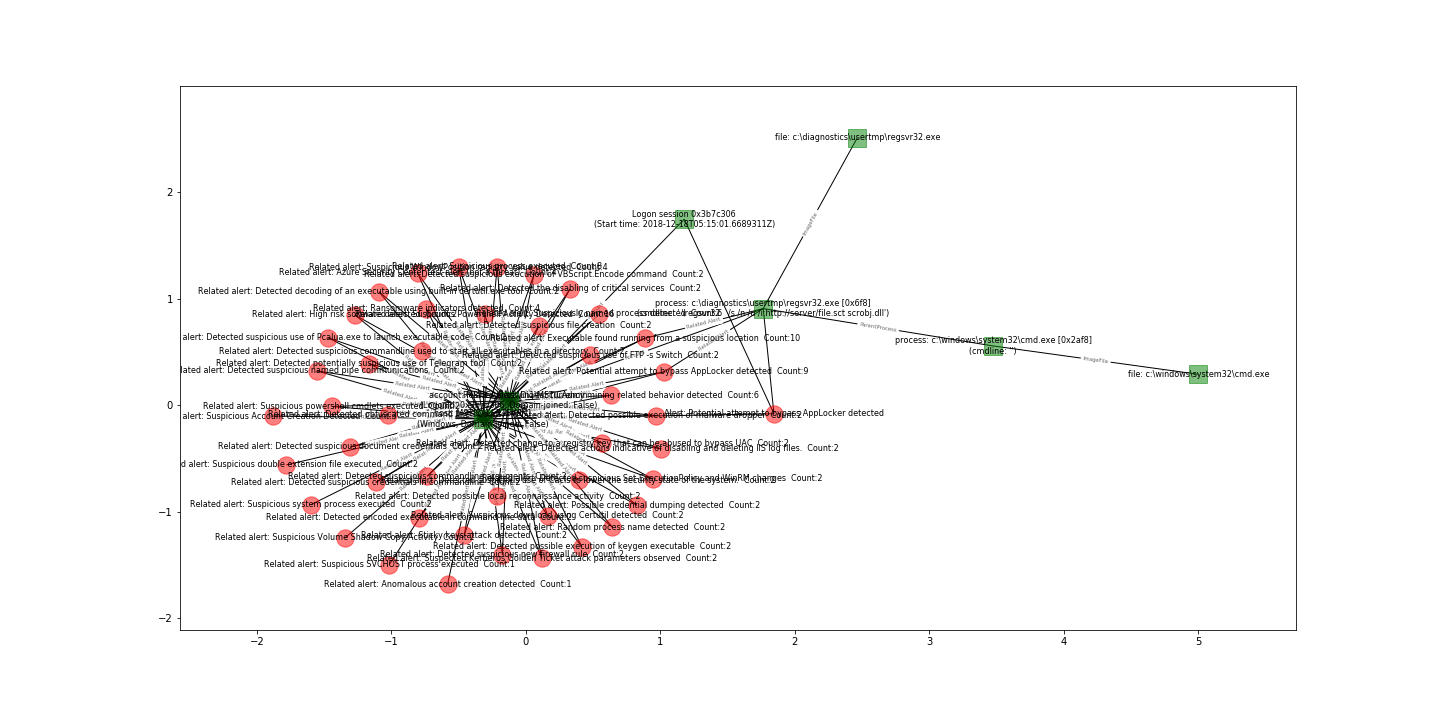

C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



In [23]:
%matplotlib notebook
%matplotlib notebook

# Draw a graph of this (add to entity graph)
related_alerts_graph = alertentity_graph.copy()

def add_alert_node(nx_graph, alert, index):
    nx_graph.add_node(alert['AlertType'] + '(R)', 
               name=alert['AlertType'], 
               time=str(alert['StartTimeUtc']),
               displayname=alert['AlertDisplayName'],
               color='red',
               count=0,
               node_type='alert')

def find_graph_node(nx_graph, node_type, target_name):
    node_prefix = '{}: {}'.format(node_type, target_name)
    nodes = [n for (n,n_type) in \
        nx.get_node_attributes(nx_graph,'entitytype').items() if n_type == node_type and n.startswith(node_prefix)]
    if len(nodes) > 0:
        return nodes[0]
    
def add_alert_graph_edge(nx_graph, source, target):
    count_attrs = nx.get_node_attributes(related_alerts_graph, 'count')
    target_node = target.AlertType + '(R)'
    if target_node in count_attrs:
        current_count = count_attrs[target_node]
    else:
        current_count = 0
    current_count += 1
    
    displayname = nx.get_node_attributes(related_alerts_graph, 'displayname')[target_node]
    description = 'Related alert: {}  Count:{}'.format(target.AlertType, current_count)
    node_attrs = { target_node : { 'count' : current_count, 'description' : description }}
    nx.set_node_attributes(related_alerts_graph, node_attrs)
    nx_graph.add_edge(source, target_node, weight=0.7, description='Related Alert')

# Create the nodes (summarized alerts of each type)
pastAlerts.apply(lambda x: add_alert_node(related_alerts_graph, x, x.name), axis=1)

# Find the existing entity and add edges to the related alert node
acct_node = find_graph_node(related_alerts_graph, 'account', alertAccountName)
proc_node = find_graph_node(related_alerts_graph, 'process', alertProcessName)
host_node = find_graph_node(related_alerts_graph, 'host', alertHostName)
pastAlerts.query('acct_match == @True').apply(lambda x: add_alert_graph_edge(related_alerts_graph, acct_node, x), axis=1)
pastAlerts.query('proc_match == @True').apply(lambda x: add_alert_graph_edge(related_alerts_graph, proc_node, x), axis=1)
pastAlerts.query('host_match == @True').apply(lambda x: add_alert_graph_edge(related_alerts_graph, host_node, x), axis=1)

draw_alert_entity_graph(related_alerts_graph, font_size=8, height=10, width=20, margin=0.1, scale=5, node_dist=1)

<a id='setquerytimeboundaries'></a>[Contents](#toc)
# Get time boundaries for subsequent queries

In [24]:
# Calculate query time boundaries
from datetime import timedelta
startTimeUtc = investigatedAlert['StartTimeUtc']

query_times = QueryTime(origin_time=startTimeUtc)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [25]:
# For Windows and Linux - set the event source strings and mappings (linux only)
# for Kusto queries
if investigatedAlert['os_family'] == 'Linux':
    if _kql_raw_result_.connection.endswith('@loganalytics'):

        # Mappings for projecting Linix Auditd logs to Windows equivalents
        proc_create_eventsource = 'LinuxAuditLog | where EventID == 14688'
        process_create_project = '''| project 
        TimeGenerated,
        EventID,
        Computer=node,
        SubjectUserName=user,
        SubjectUserSid=uid,
        SubjectUserName='',
        SubjectLogonId=ses,
        NewProcessId=pid,
        NewProcessName=exe,
        ProcessId=ppid,
        CommandLine=cmdline,
        ParentProcessName="",
        audit_user,
        auid,
        group,
        gid,
        effective_user,
        euid,
        effective_group,
        egid,
        cwd,
        success,
        name,
        TargetLogonId="",
        SourceComputerId
        | extend TimeCreatedUtc=TimeGenerated'''

        # Account logon
        account_logon_eventsource = 'LinuxAuditLog | where EventID == 1100 or EventID == 1112'
        account_logon_project = '''| project 
        TimeGenerated,
        EventID,
        Computer=node,
        SubjectUserName=acct,
        SubjectDomainName='',
        SubjectUserSid=auid,
        TargetUserName=user,
        TargetDomainName='',
        TargetUserSid=uid,
        TargetLogonId=ses,
        LogonProcessName=exe,
        LogonType=0,
        AuthPckgName=op,
        Status=res,
        audit_user,
        IpAddress=addr,
        WorkstationName=hostname,
        SourceComputerId
        | extend TimeCreatedUtc=TimeGenerated'''
        
    else:

        # Mappings for projecting Linix Auditd logs to Windows equivalents
        proc_create_eventsource = 'LinuxAuditD | where EventID == 14688'
        process_create_project = '''| project 
        TimeCreatedUtc,
        AzureResourceId,
        AzureResourceSubscriptionId,
        WorkspaceId,
        WorkspaceSubscriptionId,
        WorkspaceResourceGroup,
        SystemSource,
        SourceTags,
        AgentId,
        EventID,
        Computer=node,
        success,
        ProcessId=ppid,
        NewProcessId=pid,
        audit_user,
        auid,
        SubjectUserName=user,
        SubjectUserSid=uid,
        group,
        gid,
        effective_user,
        euid,
        effective_group,
        egid,
        SubjectLogonId=ses,
        NewProcessName=exe,
        CommandLine=cmdline,
        cwd,
        name'''
        TenantId,

        # Account logon
        account_logon_eventsource = 'LinuxAuditD | where EventID == 1100 or EventID == 1112'
        account_logon_project = '''| project 
        TimeCreatedUtc,
        AzureResourceId,
        AzureResourceSubscriptionId,
        WorkspaceId,
        WorkspaceSubscriptionId,
        WorkspaceResourceGroup,
        SystemSource,
        SourceTags,
        AgentId,
        EventID,
        Computer=node,
        SubjectUserName=acct,
        SubjectDomainName='',
        SubjectUserSid=auid,
        TargetUserName=user,
        TargetDomainName='',
        TargetUserSid=uid,
        TargetLogonId=ses,
        LogonProcessName=exe,
        LogonType=0,
        AuthPckgName=op,
        Status=res,
        audit_user,
        IpAddress=addr,
        WorkstationName=hostname'''

        


<a id='processtree'></a>[Contents](#toc)
# Get Process Tree
**!!! Note - potentially long running query**

In [32]:
# Query for process tree - gets parent/grandparent, children, grandchildren and siblings (sharing same
# parent as alert source event)

# These input values need to be set before running the query
start = query_times.start
end = query_times.end
alert_process = get_alert_process(investigatedAlert)
sourceProcessId = alert_process['ProcessId']
processName=get_process_name(alert_process)
sourceLogonId = accountLogonId
sourceParentProcessId = parentprocess['ProcessId']
system_session_id = '0x3e7'

# convert to decimal strings if Linux
if investigatedAlert['os_family'] == 'Linux':
    sourceProcessId = str(int(sourceProcessId, 16))
    sourceLogonId = str(int(sourceLogonId, 16))
    sourceParentProcessId = str(int(sourceParentProcessId, 16))
    system_session_id = '-1'
    sourceProcessName=processName
else:
    sourceProcessName=escape_windows_path(processName)

query = '''
let start = datetime({start});
let end = datetime({end});
let sourceProcessId = \'{sourceProcessId}\';
let sourceLogonId = \'{sourceLogonId}\';
let sourceParentProcessId = \'{sourceParentProcessId}\';
let system_session_id = \'{system_session_id}\';
let sourceProcess = 
materialize(
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start
    | where TimeGenerated <= end
    | where SubjectLogonId == sourceLogonId
    | where NewProcessId == sourceProcessId
    | where NewProcessName =~ \'{processName}\'
    | extend NodeRole = 'source', Level = 0);
let sourceTimeCreatedUtc = toscalar(sourceProcess | project TimeCreatedUtc | top 1 by TimeCreatedUtc desc nulls last);
let parentProcess = // Parent Process
materialize(
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start - time(1d)
    | where TimeGenerated <= end
    | where TimeGenerated <= sourceTimeCreatedUtc
    | where (SubjectLogonId == sourceLogonId or TargetLogonId == sourceLogonId)
    | where NewProcessId == sourceParentProcessId
    | extend NodeRole = 'parent', Level = 1
    | top 1 by TimeCreatedUtc desc nulls last);
let parentLogonId = toscalar(sourceProcess | top 1 by TimeCreatedUtc desc nulls last | project SubjectLogonId);
let parentTimeCreated = toscalar(sourceProcess | top 1 by TimeCreatedUtc desc nulls last | project TimeCreatedUtc);
let childProcesses = // Child Process
materialize(
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start
    | where TimeGenerated <= end
    | where SubjectLogonId == sourceLogonId
    | where ProcessId == sourceProcessId
    | extend NodeRole = 'child', Level = 1);

sourceProcess
| union (parentProcess)
| union (childProcesses)
| union
(
    // GrandParent Process (we ignore this if this is the system logonId)
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start - time(2d)
    | where TimeGenerated <= end
    | where TimeGenerated <= parentTimeCreated
    | where (SubjectLogonId == parentLogonId or TargetLogonId == parentLogonId)
    | extend NodeRole = 'parent', Level = 2 
    | join (parentProcess | project ProcessId) on $left.NewProcessId == $right.ProcessId
)
| union
(
    // GrandChild Process (we ignore this if this is the system logonId)
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start
    | where TimeGenerated <= end
    | where SubjectLogonId == sourceLogonId and SubjectLogonId != system_session_id
    | extend NodeRole = 'child', Level = 2 
    | join (childProcesses | project NewProcessId) on $left.ProcessId == $right.NewProcessId
)
| union
(
    // Sibling Process
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter}
    | where TimeGenerated >= start
    | where TimeGenerated <= end
    | where SubjectLogonId == sourceLogonId
    | where ProcessId == sourceParentProcessId
    | where NewProcessId != sourceProcessId
    | extend NodeRole = 'sibling', Level = 1
)'''.format(event_source = proc_create_eventsource,
            project_statement = process_create_project,
            subscription_filter = kql_subscription_filter(investigatedAlert),
            host_filter = kql_host_filter(investigatedAlert),
            start = start,
            end = end,
            sourceProcessId = sourceProcessId,
            sourceLogonId = sourceLogonId,
            sourceParentProcessId = sourceParentProcessId,
            processName = sourceProcessName,
            system_session_id = system_session_id)

if sourceLogonId == system_session_id:
    print('WARNING process tree can be inaccurate when navigating the system logon session: ', sourceLogonId)
    
processTree = execute_kql_query(query)
processTree = processTree.drop_duplicates()
processTree[['NodeRole', 'Level', 'TimeCreatedUtc', 'NewProcessName', 'CommandLine', 'NewProcessId', 'ProcessId', 'SubjectLogonId']]\
    .sort_values(by=['TimeCreatedUtc']).head(10)

,NodeRole,Level,TimeCreatedUtc,NewProcessName,CommandLine,NewProcessId,ProcessId,SubjectLogonId
13,parent,1,2018-12-18 05:15:01.017,C:\Windows\System32\cmd.exe,cmd.exe /c c:\Diagnostics\WindowsSimulateDetections.bat c:\Diagnostics\UserTmp,0x2af8,0x438,0x3e7
1,sibling,1,2018-12-18 05:15:01.027,C:\Windows\System32\conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,0x28c4,0x2af8,0x3b7c306
2,sibling,1,2018-12-18 05:15:01.240,C:\Windows\System32\cmd.exe,cmd /c echo Any questions about the commands executed here then please contact one of,0x2694,0x2af8,0x3b7c306
3,sibling,1,2018-12-18 05:15:01.263,C:\Windows\System32\cmd.exe,cmd /c echo timb@microsoft.com; romead@microsoft.com; ianhelle@microsoft.com; marcook@microsoft.com; dotanp@microsoft.com; liengli@microsoft.com,0x1948,0x2af8,0x3b7c306
4,sibling,1,2018-12-18 05:15:01.400,C:\Windows\System32\net.exe,net user adm1nistrator Bob_testing /add,0x1960,0x2af8,0x3b7c306
5,sibling,1,2018-12-18 05:15:01.467,C:\Windows\System32\net.exe,"net share TestShare=c:\testshare /Grant:Users,Read",0x29e0,0x2af8,0x3b7c306
6,sibling,1,2018-12-18 05:15:01.503,C:\Windows\System32\net.exe,net use q: \\MSTICAlertsWin1\TestShare Bob_testing /User:adm1nistrator,0x13c8,0x2af8,0x3b7c306
7,sibling,1,2018-12-18 05:15:01.597,C:\Windows\System32\net.exe,net use q: /delete,0x27a4,0x2af8,0x3b7c306
8,sibling,1,2018-12-18 05:15:01.613,C:\Windows\System32\net.exe,net share TestShare /delete,0x163c,0x2af8,0x3b7c306
9,sibling,1,2018-12-18 05:15:01.637,C:\Windows\System32\net.exe,net user adm1nistrator /delete,0x26b4,0x2af8,0x3b7c306


In [36]:
# Print out the text view of the process tree
import html
tree = processTree[['TimeCreatedUtc', 'NodeRole', 'Level', 'NewProcessName', 'CommandLine', 'SubjectUserName', 'NewProcessId', 'ProcessId']]
tree = tree.sort_values(by=['TimeCreatedUtc'], ascending=False)
def print_process(process_row):
    
    if process_row.NodeRole == 'parent':
        if process_row.Level > 1:
            level = 0
        else:
            level = 1 
    elif process_row.NodeRole == 'source':
        level = 2
    elif process_row.NodeRole == 'child':
        level = 3 + process_row.Level
    else:
        level = 2
        
    spaces = 20 * level * 2
    if process_row.NodeRole == 'source':
        line1 = '<b>[alert:{}] {} {}</b> [{}]'.format(
            process_row.Level,
            process_row.TimeCreatedUtc, process_row.NewProcessName, process_row.NewProcessId)
    else:
            line1 = '[{}:{}] {} <b>{}</b> [{}]'.format(
            process_row.NodeRole,
            process_row.Level,
            process_row.TimeCreatedUtc, process_row.NewProcessName, process_row.NewProcessId)
    line2 = '(Cmdline: \'{}\') [Account {}]'.format(
        process_row.CommandLine, process_row.SubjectUserName)
    
    display(HTML('<p style="margin-left: {indent}px">{txt}<br>{txt2}</p>'.format(indent=spaces, txt=line1, txt2=line2)))
#     display(HTML('<p style="margin-left: {indent}px">{txt}</p>'.format(indent=spaces, txt=line2)))

if accountLogonId == '0x3e7':
    display(HTML('<b><i>WARNING process tree can be inaccurate when navigating the system logon session: </i></b>'.
                 format(sourceLogonId)))

# TODO - print this out using markdown, include role of item
display(HTML("<h3>Alert process tree:</h3>"))
# tree[tree['NodeRole'] != 'sibling'].sort_values(by=['TimeCreatedUtc']).apply(lambda x: print_process(x), 1);
tree.sort_values(by=['TimeCreatedUtc']).apply(lambda x: print_process(x), 1);

# # Uncomment this section to view list of siblings
# display(HTML('Sibling processes:'))
# tree[tree['NodeRole'] == 'sibling'].apply(lambda x: print_process(x), 1);
# #if parent.Shape[0] == 0:
    

<a id='cmdlineiocs'></a>[Contents](#toc)
# Check for IOCs in Commandline

In [37]:
input_string = process["CommandLine"]
targetIoCString = widgets.Text(
    value=input_string,
    description='Commandline or string to search/decode :',
    disabled=False,
    layout = Layout(width='50%'),
    style = {'description_width': 'initial'}
)

display(targetIoCString)
display(HTML('Defaults to command line of alert process'))

Text(value='.\\regsvr32   /s /n /u /i:http://server/file.sct scrobj.dll', description='Commandline or string t…

In [38]:
# IoC Extraction
import re
def compile_regex(regex):
    return re.compile(regex, re.I | re.X | re.M)

# Base64 decode
base64_regex = '(?P<b64>[A-Za-z0-9+/]{30,}={0,2})'
base64_rgxc = compile_regex(base64_regex)

# IP Addresses
ip4_regex = '(?P<ipaddress>(?:[0-9]{1,3}\\.){3}[0-9]{1,3})'
ip4_rgxc = compile_regex(ip4_regex)

ip6_regex = '(?<![:.\w])(?:[A-F0-9]{1,4}:){7}[A-F0-9]{1,4}(?![:.\w])'
ip6_rgxc = compile_regex(ip6_regex)

# Dns Domains
# TODO - This also matches IP addresses
dns_regex = '((?=[a-z0-9-]{1,63}\\.)[a-z0-9]+(-[a-z0-9]+)*\\.){2,}[a-z]{2,63}'
dns_rgxc = compile_regex(dns_regex)
#dns_regex = '\\b((?=[a-z0-9-]{1,63}\\.)[a-z0-9]+(-[a-z0-9]+)*\\.){2,}[a-z]{2,63}\\b'

# Http requests
http_regex = r'''
    (?P<protocol>(https?|ftp|telnet|ldap|file)://)
    (?P<userinfo>([a-z0-9-._~!$&\'()*+,;=:]|%[0-9A-F]{2})*@)?
    (?P<host>([a-z0-9-._~!$&\'()*+,;=]|%[0-9A-F]{2})*)
    (:(?P<port>\d*))?
    (/(?P<path>([^?\# ]|%[0-9A-F]{2})*))?
    (\?(?P<query>([a-z0-9-._~!$&'()*+,;=:/?@]|%[0-9A-F]{2})*))?
    (\#(?P<fragment>([a-z0-9-._~!$&'()*+,;=:/?@]|%[0-9A-F]{2})*))?\b'''
#(/(?P<path>([a-z0-9-._~!$&'()*+,;=:@/]|%[0-9A-F]{2})*))?
http_rgxc = compile_regex(http_regex)

# File paths
# Windows
windows_path_regex = r'''
    (?P<root>[a-z]:|\\\\[a-z0-9_.$-]+||[.]+)
    (?P<folder>\\(?:[^\/:*?"\'<>|\r\n]+\\)*)
    (?P<file>[^\\/*?""<>|\r\n ]+)'''
windows_path_rgxc = compile_regex(windows_path_regex)

# simplified - this ignores some legal linux paths avoid matching too much
# TODO - also matches URLs!
linux_path_regex = '''
    (?P<root>/+||[.]+)
    (?P<folder>/(?:[^\\\\/:*?<>|\\r\\n]+/)*)
    (?P<file>[^/\\0<>|\\r\\n ]+)'''
linux_path_rgxc = compile_regex(linux_path_regex)

content_regexes = {'ipv4': ip4_rgxc, 'ip6': ip6_rgxc, 'dns': dns_rgxc, 'http': http_rgxc, 'windows_path': windows_path_rgxc, 'linux_path': linux_path_rgxc }

# base64 decoding
import base64
def decode_b64_string(input_string):
    #print('input:', input_string)
    try:
        decoded_bytes = base64.b64decode(input_string)
        try:
            decoded_string = decoded_bytes.decode('utf-8')
            #print('utf8:', decoded_string)
        except UnicodeDecodeError:
            decoded_string = decoded_bytes.decode('utf-16')
    except:
        decoded_string = input_string
    #print('output:', decoded_string)
    return decoded_string

def analyze_for_iocs(input_string, verbose=False):
    decoded_string = input_string
    
    match_pos=0
    b64match = base64_rgxc.search(decoded_string)
    if b64match != None:
        match_pos = b64match.end()
    loop_count = 0
    while b64match != None:
        # if we matched something, get the string and try to decode it
        matched_string = b64match.groupdict()['b64']
        part_dec_string = decode_b64_string(matched_string)
        if matched_string != part_dec_string:
            # if the part decoded string is different to the input, replace the this in the
            # original string
            decoded_string = decoded_string.replace(b64match.groupdict()['b64'], part_dec_string)
            #print('replaced')
        #else:
            #print('skipped')
        # increment the next search start the length of the replaced string
        match_pos += len(part_dec_string)
        # look for next match
        b64match = base64_rgxc.search(decoded_string, match_pos)
        #print('Part:', part_dec_string)
        #print('Res:', decoded_string)
        #print('Pos:', match_pos)
        # don't get into too large a loop!
        if loop_count > 20:
            break
        loop_count += 1
        
    # if we did something in the decoding - print this out
    if verbose and input_string != decoded_string:
        print('Base64 decoding of input:\'', input_string, '\'')
        print('After decode:\'', decoded_string, '\'')
        print('Searching decoded string for IoCs...')

    # now process the string for iocs
    iocs = {'ipv4': set(), 'ip6' : set(), 'dns' : set(), 'http': set(), 'windows_path': set(), 'linux_path': set()}
    
    from urllib.parse import unquote
    for (ioc_type, rgx) in content_regexes.items():
        
        search_strings = [decoded_string]
        if decoded_string != input_string:
            search_strings.append(input_string)

        for search_string in search_strings:
            match_pos = 0
            while True:
                rgx_match = rgx.search(search_string, match_pos)

                rgx_match = rgx.search(decoded_string, match_pos)
                if rgx_match != None:
                    iocs[ioc_type].add(rgx_match.group())
                    if ioc_type == 'http':
                        decoded_url = unquote(rgx_match.group())
                        decoded_match = rgx.search(decoded_url)
                        if decoded_match != None:
                            iocs[ioc_type].add(decoded_match.group())
                            iocs['dns'].add(decoded_match.groupdict()['host'])
                    match_pos = rgx_match.end()
                else:
                    break
    return iocs

found_iocs = analyze_for_iocs(input_string=targetIoCString.value, verbose=True)
print('\nIoCs found in alert process:')
found_iocs


IoCs found in alert process:


{'ipv4': set(),
 'ip6': set(),
 'dns': {'server'},
 'http': {'http://server/file.sct'},
 'windows_path': {'.\\regsvr32'},
 'linux_path': {'//server/file.sct', '/s /n /u /i:http:'}}

In [ ]:
# Analyze other processes in process tree
def show_iocs(row):
    iocs = analyze_for_iocs(row.CommandLine, verbose=True)
    found_iocs = {ioc_type:ioc_set for (ioc_type, ioc_set) in iocs.items() if len(ioc_set) > 0 }
    if len(found_iocs) > 0:
        print('[', row.NodeRole, ']', row.TimeCreatedUtc, row.NewProcessName)
        for (ioc_type, ioc_list) in found_iocs.items():
            print(' ' * 4, ioc_type)
            for ioc_item in ioc_list:
                print(' ' * 8, ioc_item)
            
tree[['TimeCreatedUtc', 'NewProcessName','CommandLine', 'NodeRole']].apply(lambda x: show_iocs(x), 1);

<a id='virustotallookup'></a>[Contents](#toc)
## Virus Total Lookup

In [ ]:
# Pull out any URLs to submit to VT
def get_iocs(row, ioc_type):
    
    iocs = analyze_for_iocs(row.CommandLine)
    found_iocs = {ioc_class:ioc_set for (ioc_class, ioc_set) in iocs.items() if len(ioc_set) > 0 and ioc_class == ioc_type }
    if found_iocs:
        return found_iocs
            
url_iocs = tree[['TimeCreatedUtc', 'NewProcessName','CommandLine', 'NodeRole']].apply(lambda x: get_iocs(x, 'http'), 1)
url_iocs = url_iocs.dropna()
url_iocs.values

In [ ]:
import os
def text_input_widget(description, defaultvalue):
    return widgets.Text(value=defaultvalue, description=description, layout = Layout(width='50%'),
    style = {'description_width': 'initial'})

VT_API_KEY = os.environ.get('VT_API_KEY')
if VT_API_KEY == None or len(VT_API_KEY) == 0:
    print('To obtain an API key sign up here https://www.virustotal.com/')
vtkey = text_input_widget('Virus Total API key:', VT_API_KEY)
display(vtkey)

In [ ]:
if VT_API_KEY != vtkey.value:
    VT_API_KEY = vtkey.value

import re

def get_vt_url_results(url_item):
    import requests
    
    url = "https://www.virustotal.com/vtapi/v2/url/report"
    headers = {"User-Agent":'VirusTotal',
                'Content-Type':'application/json'}
    values = {"resource": url_item,
              "apikey": VT_API_KEY}

    r = requests.get(url, values, headers=headers)
    if r.status_code == 200:
        return r.json()
    else:
        print('Error returned from VirusTotal: \n', r)

# slightly stricter URL regex to exclude '() from host string
http_strict_regex = r'''
    (?P<protocol>(https?|ftp|telnet|ldap|file)://)
    (?P<userinfo>([a-z0-9-._~!$&*+,;=:]|%[0-9A-F]{2})*@)?
    (?P<host>([a-z0-9-._~!$&\*+,;=]|%[0-9A-F]{2})*)
    (:(?P<port>\d*))?
    (/(?P<path>([^?\#| ]|%[0-9A-F]{2})*))?
    (\?(?P<query>([a-z0-9-._~!$&'()*+,;=:/?@]|%[0-9A-F]{2})*))?
    (\#(?P<fragment>([a-z0-9-._~!$&'()*+,;=:/?@]|%[0-9A-F]{2})*))?\b'''
http_strict_rgxc = compile_regex(http_strict_regex)

def submit_urls_to_vt(url_iocs):
    urls_to_event_map = dict()
    http_items_to_lookup = set()
    # for each 'http' item in the IoCs pd Series
    for k, v in url_iocs.items():
        if len(v) > 0:
            # get the list of values from the dictionary
            items = [vlist for vlist in v.values()]
            #
            for setitem in items:
                for httpstring in setitem:
                    match_url = http_strict_rgxc.search(httpstring)
                    if match_url == None or match_url.groupdict()['host'] == None:
                        continue

                    #print(httpstring)
                    # build the URL dropping the query string and fragments
                    clean_url = match_url.groupdict()['protocol']
                    if match_url.groupdict()['userinfo']:
                        clean_url += match_url.groupdict()['userinfo']
                    clean_url += match_url.groupdict()['host']
                    if match_url.groupdict()['port']:
                        clean_url += ':' + match_url.groupdict()['port']
                    if match_url.groupdict()['path']:
                        clean_url += '/' + match_url.groupdict()['path']

                    # get rid of some obvious false positives (localhost, local hostnames)
                    if httpstring.find('://127.0.0.1') == -1 and match_url.groupdict()['host'].find('.') != -1:
                        http_items_to_lookup.add(clean_url)
                        if clean_url in urls_to_event_map:
                            urls_to_event_map[clean_url].add(k)
                        else:
                            urls_to_event_map[clean_url] = set([k])

    vt_results = dict()
    VT_API_KEY ='fbe87704dae3d315967145642dedc8cf3301fa8186fc1358090aea9bb334b755'
    df_created = False
    #print(list(http_items_to_lookup), type(http_items_to_lookup))
    if len(http_items_to_lookup) > 0:
        for url in http_items_to_lookup:
            result = get_vt_url_results(url)
            
            if result == None:
                continue
            if not df_created:
                item_results = pd.io.json.json_normalize(result)

                df_vtresults = item_results[['resource', 'permalink', 'positives', 'url']]
                df_created = True

            else:
                item_results = pd.io.json.json_normalize(result)
                df_vtresults = df_vtresults.append(item_results[['resource', 'permalink', 'positives', 'url']], sort=False)
    
    return (df_vtresults, urls_to_event_map)


# Try submitting any found URLs
print('Submitting following items to VirusTotal')
for k,v in url_iocs.items():
    print(v)

# Submit current set to VT
(vtresults, url_event_map) = submit_urls_to_vt(url_iocs)

print('\n')
print('-' * 100)
if vtresults.shape[0] == 0:
    print('No results received from VT')
elif vtresults.query('positives > 0').shape[0] == 0:
    print('No positive results received from VT')
else:
    print('VirusTotal results: ')
    vtresults.query('positives > 0').apply(lambda x: \
        display('Resource: {res}, positives: {pos}, VTLink:  {link}'\
              .format(res=x.resource, pos=x.positives, link=x.permalink)),\
        axis=1)
print('-' * 100)

<a id='cmdlineonotherhosts'></a>[Contents](#toc)
# Alert command line - Occurrence on other hosts in subscription

In [ ]:
# Get a profile of other processes running in the subscription (current time + 2hrs earlier)
commandLine = alert_process['CommandLine']
process_binary = processName.split(investigatedAlert['path_separator'])[-1]
query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start}) - time(2h)
| where TimeCreatedUtc <= datetime({end})
| where NewProcessName endswith \'{processName}\'
| where CommandLine =~ \'{commandline}\'
'''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert, operator='!='),
           start=queryStartTimeUtc, 
           end=queryEndTimeUtc,
           processName = process_binary,
           commandline = escape_windows_path(commandLine))

proc_match_in_rest_of_sub = execute_kql_query(query)


In [ ]:
if proc_match_in_rest_of_sub.shape[0] == 0:
    print('No proceses with matching commandline found in on other hosts in subscription in previous 2 hours')
else:
    hosts = proc_match_in_rest_of_sub['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_rest_of_sub.shape[0]
    print('{numprocesses} proceses with matching commandline found on {numhosts} hosts in subscription in previous 2 hours'\
         .format(numprocesses=processes, numhosts=hosts))
    print('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_rest_of_sub'))
    print(proc_match_in_rest_of_sub[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())
    

<a id='process_session'></a>[Contents](#toc)
# Process Session

<a id='processtimeline'></a>[Contents](#toc)
## Process TimeLine

In [ ]:
separator = investigatedAlert['path_separator']
if separator == '\\':
    separator = r'\\\\'

sourceLogonId = accountLogonId

# convert to decimal strings if Linux
if investigatedAlert['os_family'] == 'Linux':
    sourceLogonId = str(int(sourceLogonId, 16))
    
query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start})
| where TimeCreatedUtc <= datetime({end})
| where SubjectLogonId == \'{accountLogonId}\'
| extend processName = tostring(split(NewProcessName, \'{separator}\')[-1])
| extend commandlineparts = arraylength(split(CommandLine, ' '))
| extend commandlinelen = strlen(CommandLine)
'''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
           accountLogonId=sourceLogonId, 
           start=queryStartTimeUtc, end=queryEndTimeUtc,
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert),
          separator = separator)

processesInlogonSession = execute_kql_query(query)


In [ ]:
# Check if timestamps have millisecond value.
# If not we will synthesize one from PIDs
# - This has following limitations:
# 1. It uses the PID range for the whole event set (not just the PIDs within a single second boundary)
# 2. It ignores PID wrapping - so if P1 has PID 0xFFFF and P2 has PID 0x1 in the same second, P1 will appear after P2 in 
# the timeline.
def pid_to_ms(pid):
    """Interpolate microsecond value based on PID ordering"""
    if isinstance(pid, str):
        if pid.strip().startswith('0x'):
            n_pid = int(pid, 16)
        else:
            n_pid = int(pid)
    else:
        n_pid = int(pid)
    assert isinstance(n_pid, int)
    return 1 + ((n_pid - min_pid) * (999998)) / (max_pid - min_pid)

use_adjusted_time = False
if processesInlogonSession.shape[0] > 2 and processesInlogonSession.at[0, 'TimeCreatedUtc'].microsecond == 0\
    and processesInlogonSession.at[1, 'TimeCreatedUtc'].microsecond == 0:
    
    max_pid = processesInlogonSession['NewProcessId'].apply(lambda x: int(x,16)).max()
    min_pid = processesInlogonSession['NewProcessId'].apply(lambda x: int(x, 16)).min()

    usecs = pd.DataFrame(processesInlogonSession.apply(lambda x: pid_to_ms(x.NewProcessId), axis=1), columns=['usec'])
    processesInlogonSession['AdjTimeCreatedUtc'] = processesInlogonSession['TimeCreatedUtc'] + pd.to_timedelta(usecs['usec'], 'us')
    use_adjusted_time = True

if use_adjusted_time:
    time_column = 'AdjTimeCreatedUtc'
else:
    time_column = 'TimeCreatedUtc'
if investigatedAlert['os_family'] == 'Linux':
    vw = processesInlogonSession[[time_column, 'NewProcessName', 'CommandLine','SubjectUserName', 'SubjectUserSid', 'audit_user', 'effective_group']].sort_values(time_column)
else:
    vw = processesInlogonSession[[time_column, 'NewProcessName', 'CommandLine','SubjectUserName', 'SubjectUserSid']].sort_values(time_column)
vw

In [ ]:
import bokeh

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.models import ColumnDataSource, DateRangeSlider, BoxAnnotation, HoverTool
from bokeh.layouts import layout, row, column, Spacer
from bokeh.models import DatetimeTickFormatter, LabelSet, Label
from bokeh.plotting import figure, show, output_notebook, reset_output

def display_timeline(processSession=processesInlogonSession, use_adjusted_time=False):
    reset_output()
    output_notebook()

    def wrap_text(source_string, wrap_len):
        if len(source_string) <= wrap_len:
            return source_string
        out_string = ''
        input_parts = source_string.split()
        out_line = ''
        for part in input_parts:
            if len(part) > wrap_len:
                if len(out_line) > 0:
                    out_string += out_line + '\n'
                    out_line = ''
                out_line = part[0:wrap_len] + '...'
            else:
                if len(out_line) > 0:
                    out_line += ' ' + part
                else:
                    out_line = part
                if len(out_line) > wrap_len:
                    out_string += out_line + '\n'
                    out_line = ''

        return out_string

    if use_adjusted_time:
        time_column = 'AdjTimeCreatedUtc'
    else:
        time_column = 'TimeCreatedUtc'
        
    wrap = lambda x: wrap_text(x, 50)
    graph_df = processSession[[time_column,'processName', 'NewProcessName', 'EventID', 'CommandLine']]\
        .assign(Tooltip = lambda x: x.CommandLine.map(wrap))
#    graph_df = processSession[['TimeCreatedUtc','processName','EventID', 'CommandLine']].assign(Tooltip = lambda x: x.CommandLine)
    graph_df['y_index'] = 1
#     if 'PoplProcessCount' not in processSession.index:
#         #graph_df['y_index'] = processSession.apply(lambda x: len(x.NewProcessName) % 10, axis=1)
#         graph_df['y_index'] = 1
#     else:
#         max_popl = processSession['PoplProcessCount'].max()
#         popl_divisor = max_popl / 10
#         graph_df['y_index'] = processSession['PoplProcessCount']

    # graph_df.assign(Tooltip = lambda x: x.CommandLine.map(wrap))
    source = ColumnDataSource(graph_df)

    tools = 'pan, box_zoom, wheel_zoom, reset, undo, redo, save, hover'
    hover = HoverTool(
            tooltips=[
                ("Process", "@NewProcessName"),
                ("CommandLine", "@Tooltip{%50s}")

            ],
            formatters={ 'Tooltip': 'printf' }
            # display a tooltip whenever the cursor is vertically in line with a glyph
            #,mode='vline'
        )


    p = figure(min_border_left=50, plot_height = 300, plot_width = 1000, 
               x_axis_label='Event Time', x_axis_type='datetime', x_minor_ticks = 10,
               tools=[hover, 'pan', 'xwheel_zoom' ],
               title='Event Timeline (hover over item to see details)')
    p.yaxis.visible = False
    # '%H:%M:%S.%3Nms
    tickFormater = DatetimeTickFormatter()
    tickFormater.days=['%d %H:%M']
    tickFormater.hours=['%H:%M:%S']
    tickFormater.minutes=['%H:%M:%S']
    tickFormater.seconds=['%H:%M:%S']
    tickFormater.milliseconds=['%H:%M:%S.%3N']
    p.yaxis
    p.xaxis[0].formatter = tickFormater
    p.circle(x=time_column, y='y_index', color='navy', alpha=0.5, size=10, source=source)

    labels = LabelSet(x=time_column, y='y_index', y_offset=5, text='processName', source=source,
                     angle='90deg', text_font_size='8pt')
    #p.add_layout(labels)
    
    x_alertLabel = pd.Timestamp(investigatedAlert['StartTimeUtc'])
    alert_label = Label(x=x_alertLabel, y=0, y_offset=10, x_units='data', y_units='data',
                 text='< Alert time', render_mode='css',
                 border_line_color='red', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=1.0)

    p.add_layout(alert_label)
    show(p)
    print('Alert start time = ', investigatedAlert['StartTimeUtc'])

In [ ]:
display_timeline(processesInlogonSession, use_adjusted_time=use_adjusted_time)

Each circle represents one or more processes. They are split into horizontal streams grouped by name similarity.
This allows easier navigation when processes have the same start times.
Note: ASC truncates times to nearest second so multiple processes appear to have the same start time.
    
Use the wheel zoom tool (3rd icon down from top right of chart) to zoom into the time line.
Use the pan tool (2nd down) to drag timeline.
The Tooltips show process name and commandline

<a id='processprevalence'></a>[Contents](#toc)
## Prevalence of processes in subscription compared with Alert host

In [ ]:
# Get a sample of 30 hostnames
query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where TimeCreatedUtc >= datetime({start})
| where TimeCreatedUtc <= datetime({end})
| distinct Computer
| take 1000
'''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
           subscription_filter = kql_subscription_filter(investigatedAlert), 
           start=queryStartTimeUtc, end=queryEndTimeUtc)

results = execute_kql_query(query)
sample_hosts_kql = ''

if results.shape[0] > 999:
    n_hosts = 'more than 1000'
else:
    n_hosts = str(results.shape[0])
    
print('Total number of hosts in subscription = {}'.format(n_hosts))

sampleSize = widgets.IntSlider(
    value=30,
    min=1,
    max=results.shape[0],
    step=1,
    description='Sample size of hosts to use:',
    layout = Layout(width='50%'),
    style = {'description_width': 'initial'})
print('Choose the number of hosts to use in the sample')
display(sampleSize)

In [ ]:
if results.shape[0] > sampleSize.value:
    # we want to take a sample of machines and not try to chew through 1000s of hosts' data
    sample_hosts = results.sample(n=sampleSize.value)['Computer'].tolist()
    sample_host_list = ','.join('\'{}\''.format(h) for h in sample_hosts)
    sample_hosts_kql = '| where Computer in ({})'.format(sample_host_list)
    
# Get a profile of other processes running on these hosts in the subscription
query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start})
| where TimeCreatedUtc <= datetime({end})
{sample_filter}
| extend processParts = split(NewProcessName, '\\\\')
| extend processName = tostring(processParts[ -1 ])
| extend commandlineparts = arraylength(split(CommandLine, ' '))
| extend commandlinelen = strlen(CommandLine)
| summarize ProcessCount = count() by processName, NewProcessName, CommandLine, commandlineparts
'''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert, operator='!='), 
           start=queryStartTimeUtc, end=queryEndTimeUtc,
           sample_filter = sample_hosts_kql)

results = execute_kql_query(query)

In [ ]:
sub_processes = results
loc_processes = processesInlogonSession
merged_prevalence = pd.merge(loc_processes, sub_processes, how='left', on=['NewProcessName', 'CommandLine'])

unique_loc_processes = merged_prevalence[merged_prevalence['ProcessCount'].isnull()][['NewProcessName','CommandLine']].drop_duplicates()
loc_processes_distinct = loc_processes[['NewProcessName','CommandLine']].drop_duplicates()


non_unique_loc_processes = merged_prevalence[merged_prevalence['ProcessCount'].notnull()][['NewProcessName','CommandLine']].drop_duplicates()

print('Comparing process name and commandline with other hosts:')
print('-'*30)
print('Number of distinct process/commandlines on this host:', len(loc_processes_distinct.index))
print('Number of distinct process/commandlines only seen on this host: ', len(unique_loc_processes.index))
print('Number of distinct process/commandlines also seen on other hosts: ', len(non_unique_loc_processes.index))

In [ ]:
#cmdline_parts = processTree.apply(lambda c: len(c.CommandLine.split(), axis=1)
#merged_prevalence = pd.merge(processTree, results, how='left', on=['NewProcessName', 'commandlineparts'])
# loc_processes.assign(commandlineparts = len(loc_processes['CommandLine'].str.split()))
# calculate cmdline parts for this machine's processes
loc_processes['commandlineparts'] = loc_processes.apply(lambda c: len(c.CommandLine.split()), axis=1)

loc_processes_distinct_fuzzy = loc_processes[['NewProcessName','commandlineparts']].drop_duplicates()


sub_processes_distinct_fuzzy = sub_processes[['ProcessCount','NewProcessName','commandlineparts']].drop_duplicates()

# merge and extract counts
merged_prevalence_fuzzy = pd.merge(loc_processes, sub_processes_distinct_fuzzy, how='left', on=['NewProcessName', 'commandlineparts'])
unique_loc_processes_fuzzy = merged_prevalence_fuzzy[merged_prevalence_fuzzy['ProcessCount'].isnull()][['NewProcessName','commandlineparts']].drop_duplicates()
non_unique_loc_processes_fuzzy = merged_prevalence_fuzzy[merged_prevalence_fuzzy['ProcessCount'].notnull()][['NewProcessName','commandlineparts']].drop_duplicates()

unique_procs = pd.merge(loc_processes, unique_loc_processes_fuzzy, how='inner', on=['NewProcessName', 'commandlineparts'])

if 'PoplProcessCount' in processesInlogonSession.index or 'PoplCommandLineParts' in processesInlogonSession.index:
    processesInlogonSession.drop(labels=['PoplProcessCount', 'PoplCommandLineParts'], axis=1)
    
processesInlogonSession['PoplProcessCount'] = merged_prevalence_fuzzy['ProcessCount']
processesInlogonSession['PoplCommandLineParts'] = merged_prevalence_fuzzy['commandlineparts']
processesInlogonSession = processesInlogonSession.fillna(value={'PoplProcessCount':0, 'PoplCommandLineParts':0})

print('Comparing process name and commandline token count with other hosts:')
print('-'*30)
print('Number of distinct process/commandline parts on this host: ', len(loc_processes_distinct_fuzzy.index))
print('Number of process commandlines only seen on this host (fuzzy match): ', len(unique_loc_processes_fuzzy.index))
print('Number of process commandlines also seen on other hosts (fuzzy match): ', len(non_unique_loc_processes_fuzzy.index))

alert_process = get_alert_process_name(investigatedAlert)
alert_commandline = get_alert_process(investigatedAlert)['CommandLine']
cmdline_parts = len(alert_commandline.split())
matched_alert_procs = sub_processes_distinct_fuzzy.query('NewProcessName == @alert_process and commandlineparts == @cmdline_parts')
if matched_alert_procs.shape[0] > 0:
    n_procs = sub_processes_distinct_fuzzy.query('NewProcessName == @alert_process and commandlineparts == 4').sum()['ProcessCount']
    print('\nFound {} processes on other hosts that match the pattern of the alert process'.format(n_procs))
    print(matched_alert_procs)
else:
    print('\nFound no processes on other hosts that match the pattern of the alert process')
    
print('\n\n{} processes in this session with no matching pattern on other hosts'.format(unique_procs.shape[0]))
print('-'*30)

print('Run the next cell to view these')
sub_percentile = 0
cmdline_filter_threshold = 0
procname_filter_threshold = 0

In [ ]:
# Unique process patterns on this host
unique_procs[['TimeCreatedUtc','SubjectUserName', 'NewProcessName', 'CommandLine']]

<a id='sessioncomparison'></a>[Contents](#toc)
## Comparison of Alert logon session processes with previous sessions on host

In [ ]:
processesInAlertSession = processesInlogonSession

# Get 24 hours of logon sessions for this account to see if there are patterns/regularity
targetAccount = processesInlogonSession.at[0, 'SubjectUserName']
targetDomain = ''
if 'SubjectDomainName' in processesInlogonSession.columns:
    targetDomain = processesInlogonSession.at[0, 'SubjectDomainName']

query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({end}) - time(1d)
| where TimeCreatedUtc <= datetime({end})
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project, start=queryStartTimeUtc, end=queryEndTimeUtc,
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert))

getPreviousLogons = execute_kql_query(query)
#display(getPreviousLogons)
%matplotlib notebook
%matplotlib notebook
prevLogonsSummary = getPreviousLogons[['TargetUserName', 'LogonType', 'EventID']].groupby(
    [ 'LogonType', 'TargetUserName']).count().unstack()
prevLogonsSummary.plot.bar(stacked=True, figsize=(5,5))
prevLogonsSummary.fillna(0)

### Visual Comparison of processes in each session
These visualizations are not meant to be interpreted directly - they simply give visual similarity/difference cues between the different sessions. Repeating similar patterns likely mean that the session is schedule or scripted and runs the same selection of processes.

Note System session visualization will not be meaningful since multiple "sessions" are combined

In [ ]:
# Get logon Sessions for last 24 hours - max of 30 (30 randomly sampled from larger number
if getPreviousLogons.shape[0] > 30:
    logonIds_24hrs = getPreviousLogons.sample(n=30)['TargetLogonId'].tolist()
else:
    logonIds_24hrs = getPreviousLogons['TargetLogonId'].tolist()

if len(logonIds_24hrs) > 0:
        
    logonId_set = str(logonIds_24hrs).replace('[', '').replace(']','')

    query = '''
    {event_source}
    {project_statement}
    | where {subscription_filter}
    | where {host_filter} 
    | where TimeCreatedUtc >= datetime({start}) - time(1d)
    | where TimeCreatedUtc <= datetime({end})
    | where SubjectLogonId in ({accountLogonId})
    | extend processName = tostring(split(NewProcessName, '\\\\')[-1])
    '''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
               accountLogonId=logonId_set, start=queryStartTimeUtc, end=queryEndTimeUtc,
               subscription_filter = kql_subscription_filter(investigatedAlert),
               host_filter = kql_host_filter(investigatedAlert))


    processesInlogonSession_24hrs = execute_kql_query(query)
    have_sessions = True
else:
    processesInlogonSession_24hrs = None
    have_sessions = False
    print('No previous logon sessions found')
    

# Process starts at 1 second sampling
def plot_session(session, title='', subplot=False, axes=None, row=0, column=0):
    first_event = session['TimeCreatedUtc'].min()
    r = session.copy()
    r['processNameLen'] = r.apply(lambda x: len(x.NewProcessName) % 10, axis=1)
    r['timeIndex'] = r.apply(lambda x: (first_event - x.TimeCreatedUtc).components.seconds % 20 , axis=1)

    if (not subplot):
        r.plot.hexbin(x='timeIndex', y='processNameLen', gridsize=10, vmin=0, title=title, ax=axes)
    else:
        r.plot.hexbin(x='timeIndex', y='processNameLen', gridsize=10, vmin=0, ax=axes[row, column], title=title)

# Plot the alert session
m_fig, m_axes = plt.subplots(nrows=1, ncols=1, figsize=(7,3))
title = 'Alert session {}'.format(processesInlogonSession['SubjectUserName'].iat[0])
plot_session(processesInlogonSession, title, subplot=False, axes=m_axes, row=0, column=0)

# Plot other sessions
if have_sessions and int(processesInlogonSession_24hrs.groupby(['SubjectLogonId']).size().count()) > 1:
    session_groups = processesInlogonSession_24hrs.groupby(['SubjectLogonId'])

    # extract the sizes of each group so that we can group them by size
    size_frame = session_groups.size().to_frame('size')

    # set up the plots
    num_plots = int(session_groups.size().count())
    
    fig, axes = plt.subplots(nrows=int(1 + num_plots/2), ncols=2, figsize=(15, num_plots * 2), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.4)
    count_plot = 0

    for x in size_frame.sort_values('size', ascending=False).index:
        events = session_groups.get_group(x)
    #for session, events in processesInlogonSession_24hrs.groupby(['SubjectLogonId']):
        row = int(count_plot / 2)
        col = count_plot % 2

        subplot_title = '{} {} {}'.format(str(events['TimeCreatedUtc'].sort_values().iat[0]), str(events['SubjectUserName'].iat[0]), x)
        plot_session(events, title=subplot_title, subplot=True, axes=axes, row=row, column=col)
        count_plot += 1
else:
    print('Low number of distinct logon ids - comparison not valid')

<a id='logonaccount'></a>[Contents](#toc)
# Logon Account

In [ ]:
# Logon session for alert account
getLogonSessionQuery = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start}) - time(5d)
| where TimeCreatedUtc <= datetime({end})
| where TargetLogonId == \'{accountLogonId}\'
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project,
           accountLogonId=sourceLogonId, start=queryStartTimeUtc, end=queryEndTimeUtc, 
          subscription_filter = kql_subscription_filter(investigatedAlert),
          host_filter = kql_host_filter(investigatedAlert))

getLogonSession = execute_kql_query(getLogonSessionQuery)


<a id='basiclogon'></a>[Contents](#toc)
## Basic Account Logon Information

In [ ]:
windows_sid = { 'S-1-0-0': 'Null SID','S-1-5-18': 'LOCAL_SYSTEM', 'S-1-5-19': 'LOCAL_SERVICE', 'S-1-5-20': 'NETWORK_SERVICE'}
administrator_sid = '500'
guest_sid = '501'
domOrMachine_sid = 'S-1-5-21'

def print_sid_info(sid):
    if sid in windows_sid:
        print('SID {} is {}'.format(sid, windows_sid[sid]))
    elif sid.endswith(administrator_sid):
        print('SID {} is administrator'.format(sid))
    elif sid.endswith(guest_sid):
        print('SID {} is guest'.format(sid))
        
    if sid.startswith(domOrMachine_sid):
        print('SID {} is local machine or domain account'.format(sid))
        
if getLogonSession.shape[0] > 0:
    accountSid = getLogonSession.at[0, 'TargetUserSid']
    accountSid = getLogonSession.at[0, 'TargetUserSid']
    logon_type_map = { 2: 'Interactive', 3: 'Network', 4: 'Batch', 5: 'Service', 7: 'Unlock', 8: 'NetworkCleartext', 
    9: 'NewCredentials', 10: 'RemoteInteractive', 11: 'CachedInteractive' } 

    print('### Account Logon')
    print('Account logon for {domain}/{name} occured at {l_time}.'.format(
        name=getLogonSession.at[0, 'TargetUserName'], 
        domain=getLogonSession.at[0, 'TargetDomainName'], 
        l_time=getLogonSession.at[0, 'TimeCreatedUtc']))

    if investigatedAlert['os_family'] == 'Windows':
        logon_type = getLogonSession.at[0, 'LogonType']
        print('Logon type: {l_type} ({l_type_desc})'.format(
            l_type=logon_type, 
            l_type_desc=logon_type_map[logon_type]))
    else:
        print('Audit user: ', getLogonSession.at[0, 'audit_user'])

    print('Target Account logon id \'{}\''.format(getLogonSession.at[0, 'TargetLogonId']))
    if getLogonSession.at[0, 'TargetLogonId'] == '0x3e7' or getLogonSession.at[0, 'TargetLogonId'] == '-1':
        print('    System logon session')

    print('\nSubject (source) account - {domain}/{name}'.format(
        name=getLogonSession.at[0, 'SubjectUserName'], 
        domain=getLogonSession.at[0, 'SubjectDomainName']))
    print('Subject Account logon id \'{}\''.format(getLogonSession.at[0, 'SubjectLogonId']))
    if getLogonSession.at[0, 'SubjectLogonId'] == '0x3e7' or getLogonSession.at[0, 'SubjectLogonId'] == '-1':
        print('    System logon session')
        
    print('Logon process: ', getLogonSession.at[0, 'LogonProcessName'])
    print('Authentication: ', getLogonSession.at[0, 'AuthPckgName'])
    print('Source IpAddress: ', getLogonSession.at[0, 'IpAddress'])
    print('Source Host: ', getLogonSession.at[0, 'WorkstationName'])
    print('Status: ', getLogonSession.at[0, 'Status'])

else:
    print('Could not find logon session for this alert account')


In [ ]:
# Get 24 hours of logon sessions for this account to see if there are patterns/regularity

targetAccount = processesInlogonSession.at[0, 'SubjectUserName']
targetDomain = ''
if 'SubjectDomainName' in processesInlogonSession.columns:
    targetDomain = processesInlogonSession.at[0, 'SubjectDomainName']

query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter} 
| where TimeCreatedUtc >= datetime({end}) - time(1d)
| where TimeCreatedUtc <= datetime({end})
| where TargetUserName == \'{targetUserName}\'
| where isempty(TargetDomainName) or TargetDomainName == \'{targetDomain}\'
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project,
           targetUserName=targetAccount, targetDomain=targetDomain, start=queryStartTimeUtc, end=queryEndTimeUtc, 
          subscription_filter = kql_subscription_filter(investigatedAlert),
          host_filter = kql_host_filter(investigatedAlert))

getPreviousLogons = execute_kql_query(query)


print('Total logon sessions recorded for this account = ', getPreviousLogons.shape[0])

<a id='recentlogonpattern'></a>[Contents](#toc)
## Time distribution of recent logons - scheduled or interactive pattern?

In [ ]:
df = getPreviousLogons
if df.shape[0] > 0:

    df['LogonHour'] = df.apply(lambda x: x.TimeCreatedUtc.hour, axis=1)
    df['LogonMinute'] = df.apply(lambda x: x.TimeCreatedUtc.minute, axis=1)
    df['LogonSecond'] = df.apply(lambda x: int(x.TimeCreatedUtc.minute * 60 + (x.TimeCreatedUtc.second / 10)), axis=1)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

    df.groupby(['LogonMinute']).aggregate({'LogonType' : 'count'}).plot.bar(#by='LogonMinute',    bins=60, 
        label='Seconds past hour', title='Per Hour Time Distribution of Logons', ax=axes[0])
    df.groupby(['LogonHour']).aggregate({'LogonType' : 'count'}).plot.bar(
        label='Logon Count Hour', title='Daily Time Distribution of Logons', ax=axes[1])

    total_logons = getPreviousLogons.shape[1]
    df.groupby(['LogonSecond'], as_index=False)['LogonType'].count()

    hour_count = df.groupby(['LogonHour']).aggregate({'LogonType' : 'count'}).shape[0]
    if hour_count < 12:
        print('Low number of hours in data ({} distinct hours) - analysis may be faulty'.format(hour_count))

    # Look for logons with a distinct timestamp
    num_of_isolated_logons = df.groupby(['LogonSecond']).filter(lambda x: (x['LogonType'].count() == 1)).shape[0]
    print('Logons in previous 24 hours: ', getPreviousLogons.shape[0])
    if num_of_isolated_logons == 0:
        print('Multiple logons occurred at same times in each hour - likely scheduled')
    else:
        print(num_of_isolated_logons, ' occurred at unique times - may indicate manually triggered')

    print('Logon patterns:')

<a id='logonfailures'></a>[Contents](#toc)
## Logon Failures

In [ ]:
failed_logon_query = '''
{event_source}
{project_statement}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start}) - time(3d)
| where TimeCreatedUtc <= datetime({end})
| where EventID == 4625 or Status == \'failed\'
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project,
           start=queryStartTimeUtc, end=queryEndTimeUtc, 
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert))

failedLogons = execute_kql_query(query)
if failedLogons.shape[0] == 0:
    display(HTML('No logon failures recorded for this host in past 3 days'))
else:
    display(failedLogons)

<a id='appendices'></a>[Contents](#toc)
# Appendices

## Saving Data to Excel
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```